SLCH002 3-7Hz for last away

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

In [2]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]

# pull out the neural data
last_away_df = last_away_ecpohs.get_data()

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif ...


/tmp/ipykernel_7286/1578682162.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


    Found the data of interest:
        t =   -3000.00 ...    2250.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated


In [4]:
## Load Behavioral Data ##
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

## Prep Behavioral Data
last_away_data['trial_numeric'] = last_away_data['trial_numeric'] - 1
last_away_data = last_away_data[last_away_data.index.isin(good_epochs)]

# Create ghost no ghost indices
no_ghost_index = last_away_data[last_away_data['TrialType'] > 16].index
ghost_index = last_away_data[last_away_data['TrialType'] <= 16].index
last_away_data

,trial_numeric,TrialType,sample,sample_before,event
0,0,8,39400,0,1
1,1,12,59400,0,1
2,2,3,71000,0,1
3,3,7,89600,0,1
4,4,16,110400,0,1
...,...,...,...,...,...
217,233,14,2730800,0,1
218,234,10,2740200,0,1
219,235,19,2750000,0,1
220,236,2,2761200,0,1


In [5]:
## Dictionary of electrode locations ##

# i3', 'i4', 'i5', 'i6', 'i7', 'K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],

ROIs = {
    'hc'     :['K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6'],
    'ofc'    :[],
    'amyg'   :[],
    'insula' :[],
    'cing'   :[]
}

hc_list = []
hc_indices = []
ofc_list = []
ofc_indices = []
amyg_list = []
insula_list = []
cing_list = []
pairs_long_name = [ch.split('-') for ch in last_away_ecpohs.info['ch_names']]
bidx = len(last_away_ecpohs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(1, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(pairs_name[ix])
        
# hc_list_test = hc_list.pop(1)

### Hippocampus

In [6]:
## separate and average by trial type ##

# separate
no_ghost_last_away = last_away_df[no_ghost_index, :, :].copy()
ghost_last_away = last_away_df[ghost_index, :, :].copy()

no_ghost_last_away_clean = no_ghost_last_away[:, bidx:len(pairs_long_name), :]
no_ghost_last_away_clean = no_ghost_last_away_clean[:, hc_indices, :].copy()

ghost_last_away_clean = ghost_last_away[:, bidx:len(pairs_long_name), :]
ghost_last_away_clean = ghost_last_away_clean[:, hc_indices, :].copy()



In [7]:
np.logspace(start = .4765, stop = .845, num = 7)

array([2.99571159, 3.45077519, 3.97496522, 4.57878235, 5.27432232,
       6.0755183 , 6.99841996])

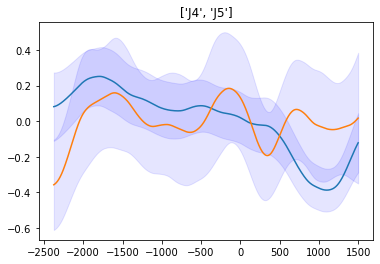

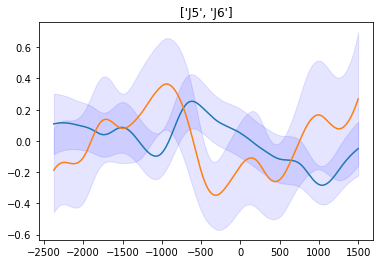

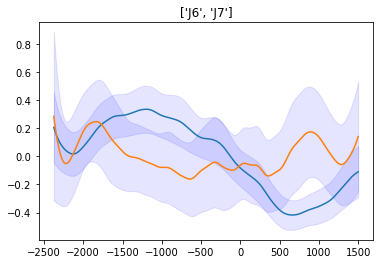

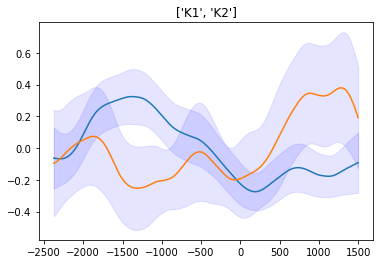

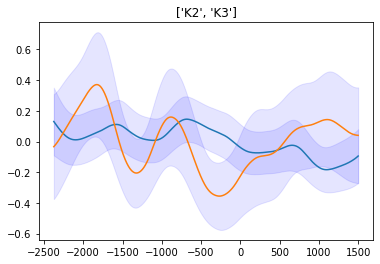

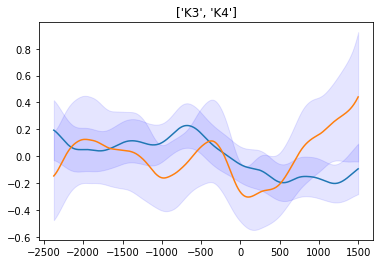

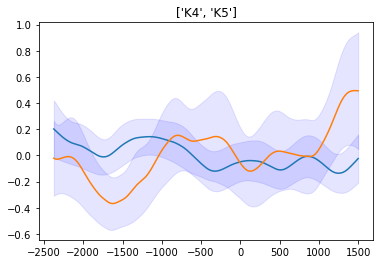

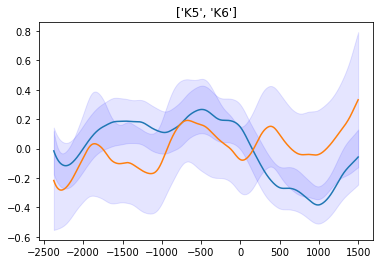

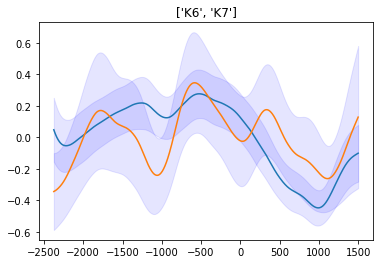

In [8]:
fs = 2000
freqs_list = np.logspace(start = .45, stop = .75, num = 7)

ghost_averages = []
no_ghost_averages = []
no_ghost_cis = []
ghost_cis = []
for ch_idx in range(len(hc_list)):
    ghost_psds = []
    no_ghost_psds = []

    for idx in range(ghost_last_away_clean.shape[0]):

        ghost_trial_psds = compute_wavelet_transform(ghost_last_away_clean[idx, ch_idx, :], fs, n_cycles = 7, freqs=freqs_list)
        ghost_trial_psds = np.array([np.abs(X)**2 for X in ghost_trial_psds])
        ghost_psds.append(ghost_trial_psds)


    for idx in range(no_ghost_last_away_clean.shape[0]):

        no_ghost_trial_psds = compute_wavelet_transform(no_ghost_last_away_clean[idx, ch_idx, :], fs, n_cycles = 7, freqs=freqs_list)
        no_ghost_trial_psds = np.array([np.abs(X)**2 for X in no_ghost_trial_psds])
        no_ghost_psds.append(no_ghost_trial_psds)

    no_ghost_psds = np.dstack(no_ghost_psds)
    ghost_psds = np.dstack(ghost_psds)


    #average
    no_ghost_psds_average = no_ghost_psds[:, 1250:9000, :].mean(axis=0)
    ghost_psds_average = ghost_psds[:, 1250:9000, :].mean(axis = 0)

    ## baseline

    ghost_psds_average_baseline = np.nan * np.ones_like(ghost_psds_average) 
    no_ghost_psds_average_baseline = np.nan * np.ones_like(no_ghost_psds_average) 

    for trial in range(ghost_psds_average.shape[1]):

        ghost_psds_average_baseline[:, trial] = (ghost_psds_average[:, trial] - ghost_psds_average[:, trial].mean())/ghost_psds_average[:, trial].std()

    for trial in range(no_ghost_psds_average.shape[1]):

        no_ghost_psds_average_baseline[:, trial] = (no_ghost_psds_average[:, trial] - no_ghost_psds_average[:, trial].mean())/no_ghost_psds_average[:, trial].std()

    times = 1e3 * last_away_ecpohs.times[1250:9000]

    y_ghost = ghost_psds_average_baseline.mean(axis = 1)
    y_no_ghost = no_ghost_psds_average_baseline.mean(axis = 1)
    
    ghost_averages.append(y_ghost)
    no_ghost_averages.append(y_no_ghost)
    
    ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in ghost_psds_average_baseline]
    no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in no_ghost_psds_average_baseline]
    
    ghost_cis.append(ghost_ci)
    no_ghost_cis.append(no_ghost_ci)
    
    plt.plot(times, y_ghost)
    plt.fill_between(times, (y_ghost-ghost_ci), (y_ghost+ghost_ci), color='b', alpha=.1)
    plt.plot(times, y_no_ghost)
    plt.fill_between(times, (y_no_ghost-no_ghost_ci), (y_no_ghost+no_ghost_ci), color='b', alpha=.1)
    plt.title(hc_list[ch_idx])
    plt.show()



In [9]:
ghost_averages = np.vstack(ghost_averages)
no_ghost_averages = np.vstack(no_ghost_averages)
no_ghost_ci = np.vstack(ghost_cis)
ghost_ci = np.vstack(no_ghost_cis)


In [10]:
ghost_averages.shape[0]

9

In [11]:
ghost_ci = np.nan * np.ones_like(ghost_averages.mean(axis = 0))
no_ghost_ci = np.nan * np.ones_like(no_ghost_averages.mean(axis = 0))

for x in range(no_ghost_ci.shape[0]):

    ghost_ci[x] = 1.96 * np.std(ghost_averages[:, x])/np.sqrt(ghost_averages.shape[0])
    no_ghost_ci[x] = 1.96 * np.std(no_ghost_averages[:, x])/np.sqrt(ghost_averages.shape[0]) 
    
    

In [12]:
p = np.empty(y_ghost.shape)
for idx in range(y_ghost.shape[0]):

    t, p[idx] = scipy.stats.ttest_ind(ghost_averages[:, idx], no_ghost_averages[:, idx])
    
# FDR correction 
p_corrected = statsmodels.stats.multitest.fdrcorrection(p[750:4750], method = 'poscorr')

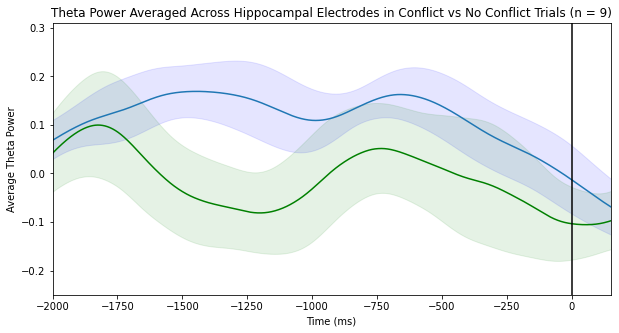

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]

shorter_times = times[0:6150]

y_ghost = ghost_averages.mean(axis = 0)[0:6150]
y_no_ghost = no_ghost_averages.mean(axis = 0)[0:6150]

plt.plot(shorter_times, y_ghost)
plt.fill_between(shorter_times, (y_ghost-ghost_ci[0:6150]), (y_ghost+ghost_ci[0:6150]), color='b', alpha=.1)
plt.plot(shorter_times, y_no_ghost, color = 'green')
plt.fill_between(shorter_times, (y_no_ghost-no_ghost_ci[0:6150]), (y_no_ghost+no_ghost_ci[0:6150]), color='green', alpha=.1)
plt.axvline(x=0, color = 'black')
# plt.plot(shorter_times[750:4750][p_corrected[0]], np.repeat(.3, len(shorter_times[750:4750][p_corrected[0]])),  lw=2, color = "orange")
plt.title("Theta Power Averaged Across Hippocampal Electrodes in Conflict vs No Conflict Trials (n = 9)" )
plt.ylabel("Average Theta Power")
plt.xlabel("Time (ms)")
plt.xlim(-2000, 150)
plt.ylim(-.25, .31)
plt.show()

In [142]:
# np.save(f"{preproc_data_dir}/{subject}_ghost_averages.npy", ghost_averages)
# np.save(f"{preproc_data_dir}/{subject}_no_ghost_averages.npy", no_ghost_averages)

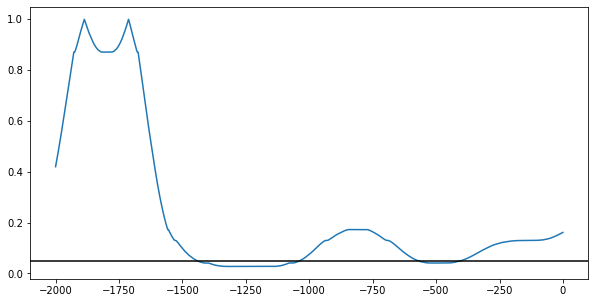

In [140]:
plt.plot(shorter_times[750:4750], p_corrected[1])
plt.axhline(y=.05, color = 'black')